


<h1><font color='Blue'><center>Programming for Data Science Final Project: Analysis of Citibike Activity between 2019 and 2020</h1></font></center>
<center>By Jenna Ellis, Isidora Filipovic, Elizabeth Wheeler, Eugenia Fomitcheva, and Kristin Mullaney</center>

<u><h2>Questions for Analysis</u></h2>

<u>**Section 1: Who are Citibike's users?**</u>

- 1.1 What is the average age of our users? Did it shift over time?
- 1.2 What is the age distribution of our users? Did it shift over time?
- 1.3 What is the gender breakdown of our users? Did it shift over time?
- 1.4 Do subscribers or casual users take more rides? Has this shifted over time?
- 1.5 What are the demographics of our subscribers as compared to our casual users?

<u>**Section 2: How are Citibikes being used?**</u>

- 2.1 Has the overall number of trips changed over time?
- 2.2 What are the most popular stations?
- 2.3 How much is each bike being used each month?
- 2.4 What are the most popular routes?
- 2.5 Which stations are likely to run out of bikes?
- 2.6 What are the most popular times of day to travel?
- 2.7 How did average ride duration change over time?

<u>**Appendix: Further Exploration with Hypothesis Testing**</u>

---------------------------------------------------------------------------

<u><h2> **Import Data**</h2></u>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
from datetime import datetime
from dateutil import parser

<u><h2>**Helper Functions**</h2></u>

In [2]:
def rainbow(hist):
    '''This is a function that turns the bars of a histogram into a rainbow.'''
    cm = plt.cm.get_cmap('gist_rainbow')
    n, bins, patches = hist
    
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

In [3]:
def distribution(dataframe, components,indx):
    '''This is a function that returns a dataframe with the percent of each column that each component accounts for.
    Note: 'components' has to be in the form of a list object. '''
    
    # Create an empty dataframe
    dist = pd.DataFrame(index = indx, columns = dataframe.columns)
    
    for col in dataframe.columns:
        # Total nonzero elements in a column
        total = len(dataframe[col].dropna())
        
        # For loop to filter for each component and convert to a percentage
        dist[col] = [round(len(dataframe[dataframe[col] == comp])/total*100, 2) for comp in components]
    return dist

In [4]:
def plot_rows(dataframe, title, xtitle, xlabels, ytitle):
    '''This is a function that takes in a dataframe and returns a plot with each row as a different line. '''
    # Set figure size 
    plt.figure(figsize = (17,5)) 
    
    # Set colormap to cycle through number of components in distribution (aka the number of rows)
    colormap = plt.cm.gist_ncar # choose color scheme 
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1,dataframe.shape[0])))) # set color cycler to cycle through number of rows 
    
    for x in range(dataframe.shape[0]):
        plt.plot(dataframe.iloc[x,:].values, label = dataframe.index[x]) # Plot each row
    
    # Set plot attributes
    plt.legend(loc = 'lower right', frameon = True, framealpha= 1)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(title)  
    plt.xticks(range(0,dataframe.shape[1]),xlabels) # Overlay x axis labels 
    plt.show()

<u><h2>**Declarations**</h2></u>

In [5]:
gen_data = lambda year: [pd.read_csv('%4d%02d-citibike-tripdata.csv' % (year, month)) for month in range(1, 13)]
data19_20 = gen_data(2019) + gen_data(2020)

In [6]:
# Set variables to be used for plots throughout the project
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months2y =  ['January 2019', 'February 2019', 'March 2019', 'April 2019', 'May 2019', 'June 2019', 'July 2019', 'August 2019', 'September 2019', 'October 2019', 'November 2019', 'December 2019','January 2020', 'February 2020', 'March 2020', 'April 2020', 'May 2020', 'June 2020', 'July 2020', 'August 2020', 'September 2020', 'October 2020', 'November 2020', 'December 2020']
short_months2y = ['Jan19','Feb19','Mar19','Apr19','May19', 'Jun19','Jul19','Aug19','Sep19','Oct19','Nov19','Dec19','Jan20','Feb20','Mar20','Apr20','May20','Jun20','Jul20','Aug20','Sep20','Oct20','Nov20','Dec20']

<u><h2> **Data Cleaning**</u></h2>

Our given dataset was already pre-cleaned. Additionally, we chose to eliminate any rides from riders over the age of 100 as we view these as outliers and any trips with a duration over 10 hours.

In [7]:
#Cleanse data 
for indx, data in enumerate(data19_20):
    data['birth year'] = data['birth year'].astype(int)
    data['age'] = int(data['starttime'][0][:4]) - data['birth year']
    data19_20[indx] = data[(data['age'] <= 100) & (data['tripduration'] <= 36000)] #cleanse for age and 10H+trips
#data19_20[indx] = data[data['tripduration'] <= 36000] #cleanse for 10h+ trips

<h2>Section 1: Who are Citibike's users?</h2>

**1.1 What is the average age of our users? Did it shift over time?**

Note: Since we do not have any customer identifying information to account for how many rides each rider took, we can only calculate the average age per ride. 

In [8]:
# First, we must figure out which month had the most rides, so we can create a dataframe that has enough rows to fit that month. 
# If we don't do this, the dataframe will contain only as many rows as there were rides in January of 2019.

most_monthly_rides = 0
for month in data19_20:
    if month.shape[0] > most_monthly_rides:
        most_monthly_rides = month.shape[0]
        
print('The most rides taken in one month was',most_monthly_rides,'!')

The most rides taken in one month was 2484762 !


In [9]:
# Create a dataframe of null values. Each row is a ride. Each column is a month between 2019 and 2020.
Ages2019_2020 = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))

#fill the dataframe by pulling the age columns from each month's data
for indx, data in enumerate(data19_20):
    Ages2019_2020[months2y[indx]] = data['age']

Ages2019_2020.head(5)

,January 2019,February 2019,March 2019,April 2019,May 2019,June 2019,July 2019,August 2019,September 2019,October 2019,...,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020,December 2020
0,48.0,30.0,30.0,37.0,36.0,27.0,53.0,23.0,51.0,26.0,...,40.0,30.0,27.0,23.0,34.0,22.0,41.0,25.0,31.0,32.0
1,55.0,29.0,39.0,36.0,50.0,32.0,23.0,21.0,50.0,27.0,...,29.0,46.0,31.0,51.0,30.0,54.0,29.0,22.0,50.0,32.0
2,32.0,32.0,32.0,31.0,41.0,29.0,33.0,31.0,50.0,24.0,...,29.0,38.0,82.0,32.0,51.0,51.0,36.0,24.0,31.0,43.0
3,29.0,55.0,32.0,37.0,22.0,32.0,31.0,31.0,29.0,27.0,...,31.0,24.0,24.0,51.0,22.0,30.0,30.0,27.0,39.0,38.0
4,40.0,40.0,28.0,33.0,52.0,46.0,22.0,54.0,27.0,27.0,...,27.0,43.0,27.0,23.0,28.0,51.0,51.0,31.0,30.0,23.0


In [10]:
print('The average age of a rider over the 2019 and 2020 period was',round(Ages2019_2020.mean().mean(),2),'years old!')

The average age of a rider over the 2019 and 2020 period was 39.01 years old!


In [11]:
#Create a dataframe containing the average age of the riders for each month 
Average_Age_per_Ride = pd.DataFrame({'Month':Ages2019_2020.describe().loc['mean'].values}, index = months2y)

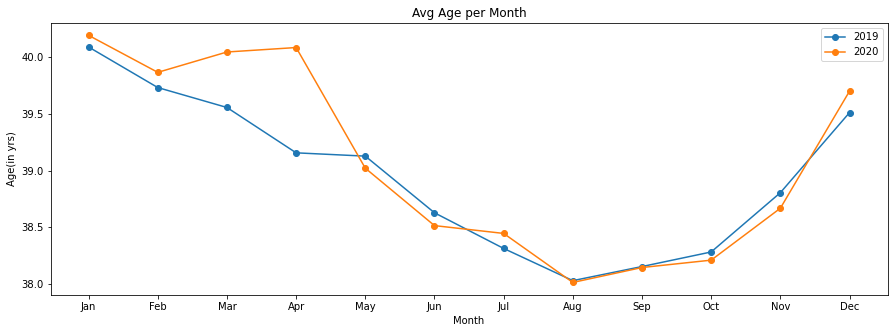

In [12]:
#Plot average age
plt.figure(figsize=(15,5))
plt.xlabel('Month')
plt.ylabel('Age(in yrs)')
plt.title('Avg Age per Month')
plt.plot(Average_Age_per_Ride.iloc[:12].values, label ='2019', marker='o')
plt.plot(Average_Age_per_Ride.iloc[12:].values, label = '2020', marker='o')
plt.xticks(range(12),months)
plt.legend()

The average age of riders over the 2019-2020 period was 39 years old. During both 2019 and 2020, the average age of riders attained a minimum in August and rose to a maximum in January. Between February and April of 2020, the average age of Citibike riders increased unlike the same period in 2019 which saw a decrease in average age. One possible explanation for this difference is that older people may have been more cautious at the onset of covid, electing to ride bikes outside rather than risk exposure on the subway and other closed-space public transport systems. 

**1.2 What is the age distribution of our riders? Did it shift over time?**

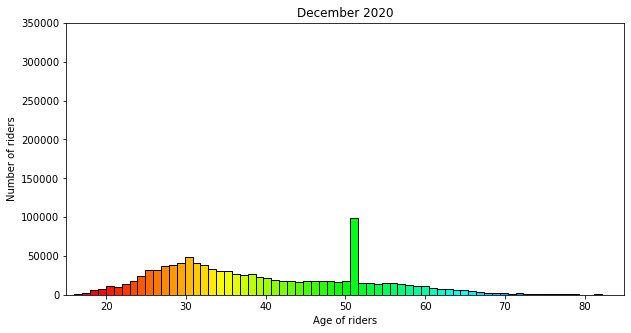

In [13]:
# Create an animated histogram displaying the ages of the riders each month.
from IPython.display import clear_output
import time

for x in Ages2019_2020.columns:
    clear_output(wait=True)
    
    plt.figure(figsize=(10,5))
    rainbow(plt.hist(Ages2019_2020[x], bins=85, color='pink', edgecolor='black')) #bins at 85 so that each age has a bin (16-100)
    plt.axis((15, 85, 0, 350000))
    plt.ylabel('Number of riders')
    plt.xlabel('Age of riders')
    plt.title(x)
    plt.show() 
    
    time.sleep(1.0)

There is a notable spike in number of rides for users aged 50 in 2019 and 51 in 2020 (corresponding to birth year of 1969 for each). Such a distinct jump in citibike popularity within this birth year seems unlikely. One explanation for this spike is data collection methods. It could be that the default birth year for citibike is 1969. In order to further investigate this explanation, we look at the histogram of birth year by usertype, theorizing that customers are less likely than subscribers to accurately identifying their birth year. 

In [14]:
sub_byear = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))
cust_byear = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))

#fill the dataframes by pulling the birth year columns from each month's data
for indx, data in enumerate(data19_20):
    sub_byear[months2y[indx]] = data.loc[(data['usertype'] == 'Subscriber'), 'birth year']
    cust_byear[months2y[indx]] = data.loc[(data['usertype'] == 'Customer') ,'birth year']

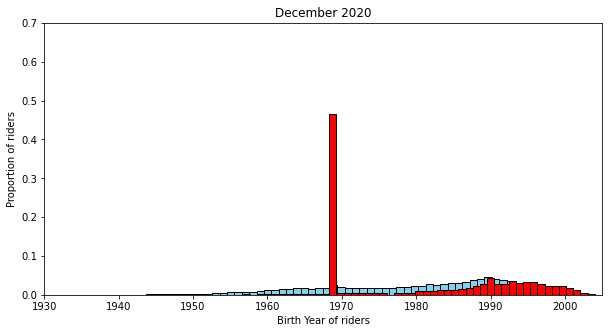

In [15]:
for x in sub_byear.columns:
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.hist(sub_byear[x], bins=85, color='skyblue', edgecolor='black', density='true')
    plt.hist(cust_byear[x], bins=85, color='red', edgecolor='black', density='true')
    plt.axis((1930, 2005, 0, .7))
    plt.ylabel('Proportion of riders')
    plt.xlabel('Birth Year of riders')
    plt.title(x)
    plt.show() 
    
    time.sleep(1.0)

The proportion of casual riders with birth year of 1969 is consistently above 40% each month, indicating that the spike in number of riders aged 50/51 is in part due to the overrepresentation in customer user type. This supports the theory that customers are less likely to enter their true birth year thus skewing the data.

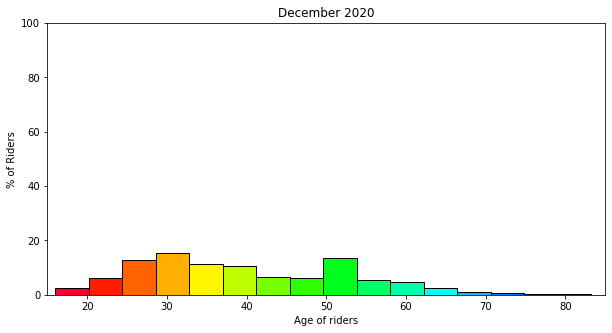

In [16]:
# Create an animated histogram displaying the age distribution of the riders each month (as a percent).

for x in Ages2019_2020.columns: 
    clear_output(wait=True)
    
    # filter each months data to remove null values
    data = list(filter(lambda x: pd.notna(x), Ages2019_2020[x]))
    
    plt.figure(figsize=(10,5))
    rainbow(plt.hist(data, bins=20, color='pink', edgecolor='black', weights=np.ones(len(data))*100/len(data)))
    plt.axis((15, 85, 0, 100))
    plt.ylabel('% of Riders')
    plt.xlabel('Age of riders')
    plt.title(x)
    plt.show() 
    
    time.sleep(1.0)

In [17]:
# Create a dataframe displaying the age distribution of riders each month

# Set start age, end age and the increment you want. 
start = 15
end = 85
inc = 5

# Create a blank dataframe to fill with distribution of ages.
Age_dist = pd.DataFrame()
Age_dist['range'] = ['%s-%s' % (age, age+inc) for age in range(start, end, inc)]
Age_dist.set_index('range')

data = Ages2019_2020

for x in data.columns:
    # Create an empty list to fill with the distribution of ages for month x
    month_data = []
    for age in range(start, end, inc):
        # Fill list 'month_dist'
        month_data.append(len(data[(data[x] >= age) & (data[x] < age + inc)])/len(data[data[x].notna()]))
    Age_dist[x] = month_data
    
Age_dist

,range,January 2019,February 2019,March 2019,April 2019,May 2019,June 2019,July 2019,August 2019,September 2019,...,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020,December 2020
0,15-20,0.005788,0.005670,0.007299,0.009031,0.008909,0.010646,0.012855,0.013012,0.012491,...,0.006701,0.005181,0.007341,0.011783,0.012403,0.015192,0.016353,0.016912,0.017588,0.016418
1,20-25,0.046027,0.054284,0.057442,0.062385,0.063578,0.069968,0.077002,0.080323,0.087487,...,0.058055,0.046309,0.058739,0.072289,0.073247,0.082822,0.085525,0.085689,0.081749,0.070737
2,25-30,0.170126,0.173755,0.177067,0.184407,0.183588,0.193407,0.194392,0.201719,0.195167,...,0.172101,0.167732,0.187304,0.193276,0.195475,0.201797,0.199303,0.196356,0.185474,0.166006
3,30-35,0.179070,0.181667,0.182148,0.182665,0.181147,0.183473,0.184551,0.186123,0.178383,...,0.178562,0.201754,0.207104,0.201431,0.197212,0.194831,0.186858,0.185869,0.182722,0.176361
4,35-40,0.143725,0.142427,0.136174,0.130617,0.128882,0.126142,0.127147,0.124744,0.123575,...,0.129931,0.128968,0.121405,0.117507,0.119252,0.115436,0.114405,0.114853,0.117559,0.121978
5,40-45,0.106924,0.102681,0.098856,0.092565,0.092753,0.087950,0.086328,0.082613,0.086546,...,0.092872,0.085094,0.075557,0.073392,0.076010,0.071770,0.074500,0.076102,0.079263,0.086788
6,45-50,0.096153,0.092666,0.088402,0.080934,0.081425,0.075520,0.072009,0.067997,0.075025,...,0.080698,0.071199,0.060386,0.058959,0.058721,0.055184,0.060647,0.063748,0.068647,0.078967
7,50-55,0.112619,0.112616,0.124681,0.142367,0.150295,0.150829,0.145498,0.148799,0.141528,...,0.145283,0.172889,0.187479,0.177442,0.173793,0.174278,0.167912,0.162575,0.157623,0.148583
8,55-60,0.068785,0.066024,0.062659,0.056958,0.054793,0.051612,0.050010,0.047225,0.050607,...,0.063552,0.055789,0.043892,0.043315,0.043902,0.041583,0.044280,0.046108,0.051295,0.063080
9,60-65,0.041650,0.039565,0.037619,0.034063,0.031972,0.029795,0.029507,0.027931,0.028891,...,0.041433,0.035923,0.027978,0.028250,0.027789,0.026263,0.028446,0.029056,0.031985,0.039646


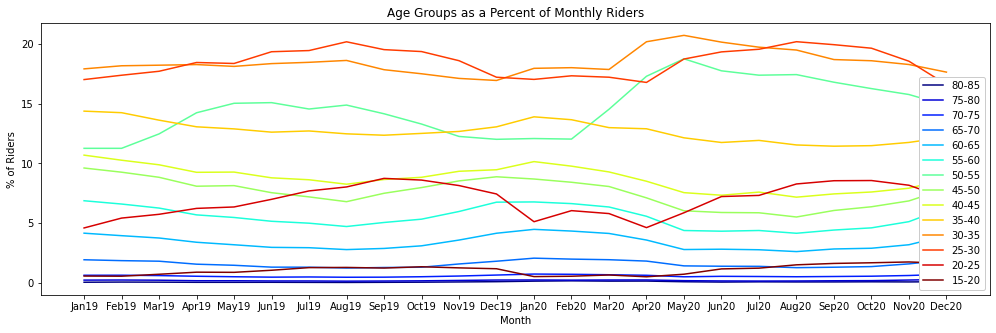

In [18]:
# Plot each row of the dataframe Age_dist 

plt.figure(figsize = (17,5)) #set figure size 

colormap = plt.cm.gist_ncar # set color scheme for plot
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1,14)))) # to cycle through colors for each line plotted

for x in range(14):
    plt.plot(Age_dist.iloc[13-x,1:].values, label = Age_dist.iloc[13-x,0]) #plot each age group as a percent of monthly riders 

plt.legend(loc = 'lower right', frameon = True, framealpha= 1)
plt.xlabel('Month')
plt.ylabel("% of Riders")
plt.title('Age Groups as a Percent of Monthly Riders')

plt.xticks(range(0,24),short_months2y)
plt.yticks(np.arange(0,.25,step=.05),[int(x) for x in np.linspace(0,20,5)])
plt.show()

It is evident that younger riders tend to account for a larger percentage of ridership. This can be observed in the rainbow effect of the graph. The two groups that seem to be outliers are the 15-19 age group and the 50-54 age group. The 15-19 age group seems to account for a smaller percent of ridership as compared to the next yougest age groups. This could be in part because Citibike's minimum age is 16, but this still would not entirely account for the sharp decrease in ridership in this group in particular. Another reasonable explanation for might be that riders ages 15-19 are less likely to be subscribers. As subscribers vastly outnumber customers in terms of number of rides per month, this may explain the low percentage for 15-19 age group. It is worth noting that both the 15-19 and 20-24 age groups exhibited more seasonal variation that other groups. Specifically, they both exbhibited a large uptick in ridership around the summer months. 

The 50-54 age group is extremely interesting in that they consistently account for a larger percentage of ridership than the 45-49 and the 55-59 groups combined. This group also exhibited an anomalous increase in ridership between January and May of 2020. Between this time, this group went from 11% to almost 19% of the overall riders. By comparison, the 55-59 age group decreased from 6% to just over 4% of riders during this same time period.


**1.3 What is the gender breakdown of our users? Did it shift over time?**

For our data:
- 0 = unknown 
- 1 = male
- 2 = female

In [19]:
Gender2019_2020 = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))

#fill the dataframe by pulling the gender columns from each month's data
for indx, data in enumerate(data19_20):
    Gender2019_2020[months2y[indx]] = data['gender']

Gender2019_2020

,January 2019,February 2019,March 2019,April 2019,May 2019,June 2019,July 2019,August 2019,September 2019,October 2019,...,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020,December 2020
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0
1,1.0,1.0,1.0,1.0,0.0,2.0,1.0,2.0,0.0,1.0,...,2.0,1.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,1.0
2,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,...,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0
3,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
2484758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2484759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2484760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [20]:
genders = [0,1,2] 
indx = ['0: Unknown', '1: Male', '2: Female']
gend_dist = distribution(Gender2019_2020, genders, indx)
gend_dist

,January 2019,February 2019,March 2019,April 2019,May 2019,June 2019,July 2019,August 2019,September 2019,October 2019,...,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020,December 2020
0: Unknown,3.51,3.88,5.36,7.80,8.72,9.32,8.96,9.6,8.40,7.33,...,7.6,11.43,14.09,13.31,12.90,13.19,12.26,11.49,10.45,8.66
1: Male,75.18,74.56,72.51,69.02,67.24,65.85,66.09,65.3,65.95,68.16,...,67.7,60.47,54.95,55.53,57.01,57.15,57.73,59.39,60.93,64.65
2: Female,21.31,21.57,22.13,23.18,24.04,24.83,24.94,25.1,25.64,24.51,...,24.7,28.10,30.96,31.16,30.08,29.66,30.01,29.12,28.62,26.69


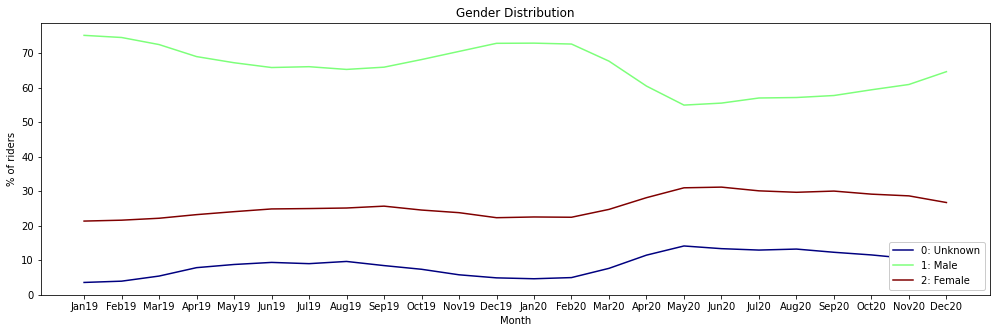

In [21]:
plot_rows(gend_dist, 'Gender Distribution','Month',short_months2y,'% of riders')

Throughout 2019 and 2020, men were the largest group by gender each month. They ranged between 75.17% of riders in January 2019 and 54.92% of riders in May 2020. Both women and unknown saw an increase as a percent of overall riders between February and May of 2020. Women peaked in May of 2020 with 30.96% of riders and unknown peaked in May of 2020 with 14.13% of riders.

**1.4 Do subscribers or casual users take more rides? Has this shifted over time?**


In [22]:
# Create a dataframe of null values with each row being a ride and each column being a month between 2019 and 2020. 
Subtype2019_2020 = pd.DataFrame(columns = months2y, index=range(most_monthly_rides))

#fill the dataframe by pulling the customer type columns from each month's data
for indx, data in enumerate(data19_20):
    Subtype2019_2020[months2y[indx]] = data['usertype']

In [23]:
#Create a dataframe of customer types as a percent of monthly customers
cust_type = ['Subscriber','Customer']
Cust_dist = distribution(Subtype2019_2020, cust_type,cust_type)
Cust_dist

,January 2019,February 2019,March 2019,April 2019,May 2019,June 2019,July 2019,August 2019,September 2019,October 2019,...,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020,December 2020
Subscriber,95.86,95.11,92.0,87.04,84.72,82.49,82.69,81.09,82.25,85.89,...,85.59,75.7,68.06,69.48,72.75,71.8,73.08,75.72,78.48,84.57
Customer,4.14,4.89,8.0,12.96,15.28,17.51,17.31,18.91,17.75,14.11,...,14.41,24.3,31.94,30.52,27.25,28.2,26.92,24.28,21.52,15.43


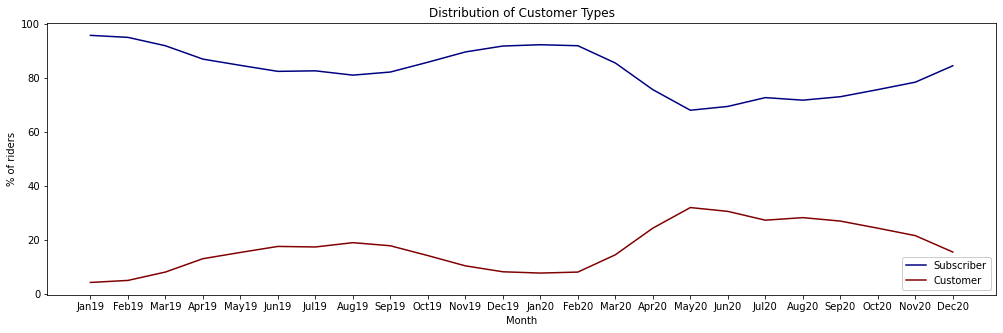

In [24]:
plot_rows(Cust_dist ,'Distribution of Customer Types','Month',short_months2y,'% of riders')

We can see that we have far more Subscribers than we do casual users. Between March and May of 2020, the number of rides taken by Subscribers fell precipitously while the number of rides taken by casual users climbed. One possible explanation for this observation is that many subscribers pre-pandemic used citibike to commute to work. As remote working became the norm during the first few months of the pandemic, the commuting subscribers no longer used citibike as regularly.

**1.5 What are the demographics of our subscribers as compared to those of our casual users?**

About 45% of casual riders have their gender listed as unknown as compared to less than 2% for subscribers. To compensate for this, we filtered out unknown values (gender = 0). Note that this type of data capturing deficiency also supports the theory around birth year for casual riders. For casual riders, the gender and birth year fields are missing or likely inaccurate.

In [25]:
sub_gender = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))
cus_gender = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))

#fill the dataframes by pulling the gender columns from each month's data
for indx, data in enumerate(data19_20):
    sub_gender[months2y[indx]] = data.loc[(data['usertype'] == 'Subscriber') & (data['gender'] != 0), 'gender']
    cus_gender[months2y[indx]] = data.loc[(data['usertype'] == 'Customer') & (data['gender'] != 0),'gender']

In [26]:
genders = [1,2] 
indx = ['1: Male', '2: Female']
sub_gen = distribution(sub_gender, genders, indx)
cus_gen = distribution(cus_gender, genders, indx)

In [27]:
sub_gen

,January 2019,February 2019,March 2019,April 2019,May 2019,June 2019,July 2019,August 2019,September 2019,October 2019,...,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020,December 2020
1: Male,77.99,77.7,77.09,75.72,74.74,73.8,73.75,73.55,73.24,74.36,...,74.29,70.0,66.53,66.29,67.09,67.45,67.28,68.16,68.86,71.1
2: Female,22.01,22.3,22.91,24.28,25.26,26.2,26.25,26.45,26.76,25.64,...,25.71,30.0,33.47,33.71,32.91,32.55,32.72,31.84,31.14,28.9


In [28]:
cus_gen

,January 2019,February 2019,March 2019,April 2019,May 2019,June 2019,July 2019,August 2019,September 2019,October 2019,...,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020,December 2020
1: Male,74.69,73.09,66.91,63.99,62.63,62.71,63.08,62.49,62.72,65.32,...,62.97,59.2,54.92,55.79,58.02,58.85,59.17,61.56,62.98,67.56
2: Female,25.31,26.91,33.09,36.01,37.37,37.29,36.92,37.51,37.28,34.68,...,37.03,40.8,45.08,44.21,41.98,41.15,40.83,38.44,37.02,32.44


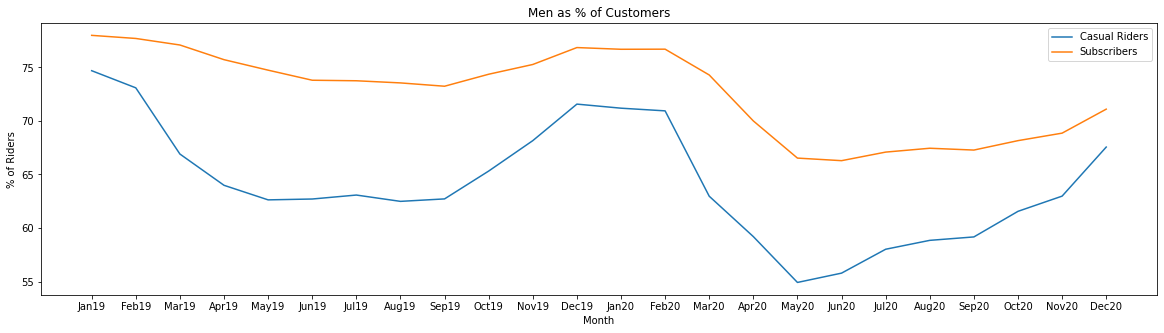

In [29]:
plt.figure(figsize=(20,5))
plt.xlabel('Month')
plt.ylabel('% of Riders')
plt.title('Men as % of Customers')
plt.plot(cus_gen.iloc[0,:].values, label = 'Casual Riders')
plt.plot(sub_gen.iloc[0,:].values, label = 'Subscribers')
plt.xticks(range(24), short_months2y)
plt.legend()
plt.show()

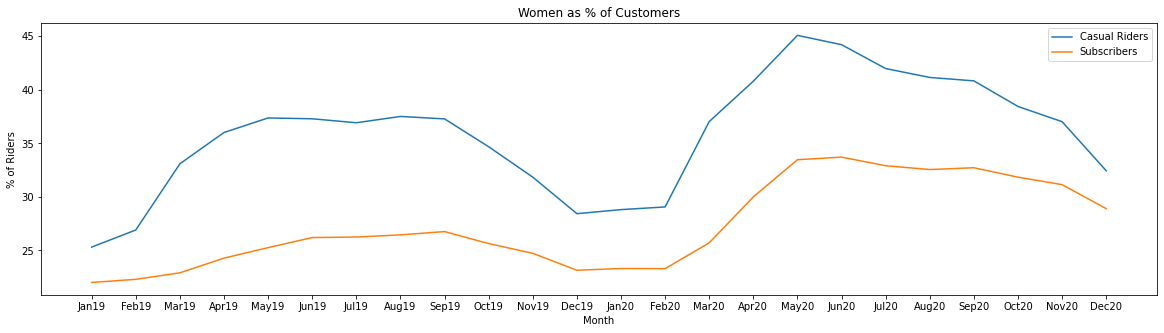

In [30]:
plt.figure(figsize=(20,5))
plt.xlabel('Month')
plt.ylabel('% of Riders')
plt.title('Women as % of Customers')
plt.plot(cus_gen.iloc[1,:].values, label = 'Casual Riders')
plt.plot(sub_gen.iloc[1,:].values, label = 'Subscribers')
plt.xticks(range(24), short_months2y)
plt.legend()
plt.show()

In [31]:
sub_age = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))
cus_age = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))

#fill the dataframes by pulling the age columns from each month's data
for indx, data in enumerate(data19_20):
    sub_age[months2y[indx]] = data.loc[(data['usertype'] == 'Subscriber'), 'age']
    cus_age[months2y[indx]] = data.loc[(data['usertype'] == 'Customer'),'age']

In [32]:
# Set start age, end age and the increment you want. 
start = 15
end = 85
inc = 10

# Create a blank dataframe to fill with distribution of ages.
Subage = pd.DataFrame(index = ['%s-%s' % (age, age+inc) for age in range(start, end, inc)])

data = sub_age

for x in data.columns:
    # Create an empty list to fill with the distribution of ages for month x
    month_data = []
    for age in range(start, end, inc):
        month_data.append(len(data[(data[x] >= age) & (data[x] < age + inc)])/len(data[data[x].notna()]))
    Subage[x] = month_data
    
Subage = Subage*100

In [33]:
# Create a blank dataframe to fill with distribution of ages.
Cusage = pd.DataFrame(index = ['%s-%s' % (age, age+inc) for age in range(start, end, inc)])

data = cus_age

for x in data.columns:
    # Create an empty list to fill with the distribution of ages for month x
    month_data = []
    for age in range(start, end, inc):
        month_data.append(len(data[(data[x] >= age) & (data[x] < age + inc)])/len(data[data[x].notna()]))
    Cusage[x] = month_data
    
Cusage = Cusage*100

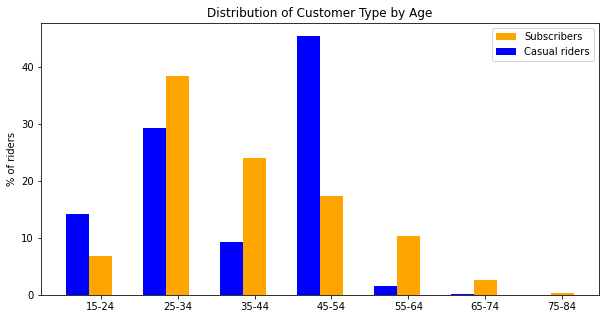

In [34]:
sub_means = list(Subage.mean(axis=1).values)
cus_means = list(Cusage.mean(axis=1).values)

labels= ['%s-%s' % (age, age+inc-1) for age in range(start, end, inc)]
plt.figure(figsize =(10,5))
x1 = [1,2,3,4,5,6,7]
x2 = [.7,1.7,2.7,3.7,4.7,5.7,6.7]
ax = plt.subplot()
ax.bar(x1,sub_means, width=0.3, color='orange',align ='center', label='Subscribers')
ax.bar(x2, cus_means, width=0.3, color ='b', align='center',label='Casual riders')
ax.set_ylabel('% of riders')
ax.set_title('Distribution of Customer Type by Age')
plt.xticks(x1, labels)
plt.legend()
plt.show()

Gender:
There seems to be a skew towards men being subscribers. They consistently account for a larger chunk of the subscriber rides than they do casual rides. Women seem to be the opposite, consistently accounting for a larger chunk of the casual rides as compared to subscriber rides. Both casual and subscription rides followed a similar pattern in seeing fewer female riders around January. This was true for both 2019 and 2020.

Age:
It seems that the proportion of subscription rides decreases steadily from the 25-34 age group onward, and casual rides increase in frequency up until the 45-54 age group. 
Notably, subscriber rides outnumber customer rides in every age group apart from 15-24 and 45-54. This observation is consistent with a previous observation that the birth year of 1969 accounts for at least 40% of all customer rides across all 24 months. This graph also supports the theory that riders aged 15-19 are less likely to be subscribers than riders in other age groups. 


<h2>Section 2: How are Citibike's being used?</h2>

**2.1 Has the overall number of trips changed over time?**

In [35]:
trips_per_month =[]
for data in data19_20:
    trips_per_month.append(data.shape[0])

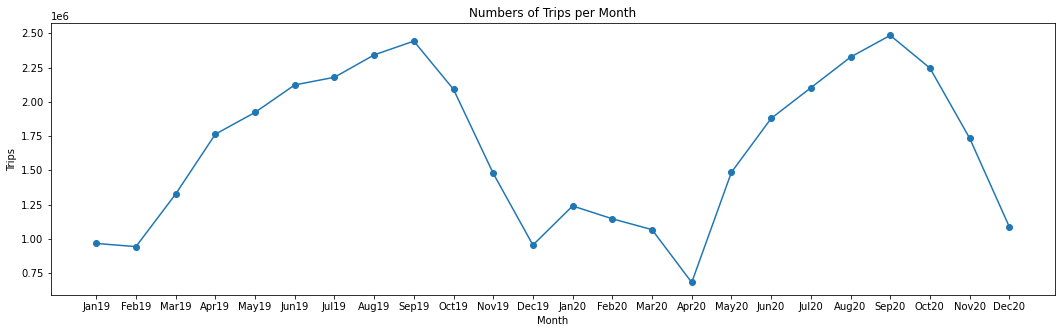

In [36]:
plt.figure(figsize=(18,5))
plt.title("Numbers of Trips per Month")
plt.ylabel('Trips')
plt.xlabel('Month')
plt.xticks(range(24),short_months2y)
plt.plot(trips_per_month, marker='o')
plt.show()

Despite the confounding factor of the pandemic, the line graph suggests a seasonality to volume of rides with a decrease in trips during colder month and a gradual increase with warmer weather. 

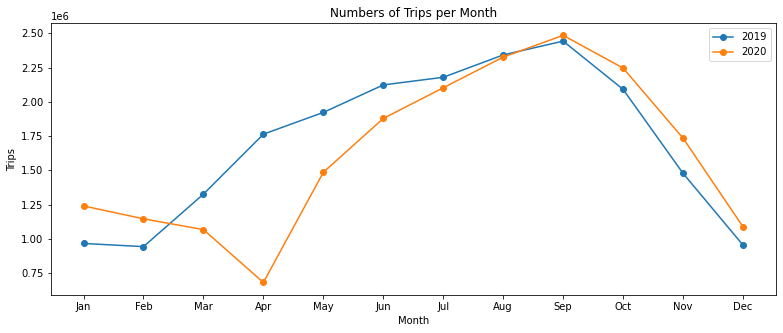

In [37]:
plt.figure(figsize=(13,5))
plt.title("Numbers of Trips per Month")
plt.ylabel('Trips')
plt.xlabel('Month')
plt.xticks(range(12),months)
plt.plot(trips_per_month[:12], marker='o', label='2019')
plt.plot(trips_per_month[12:], marker='o', label='2020')
plt.legend()
plt.show()

The number of trips taken between March and July 2020 was below 2019 levels but by August 2020 the number of rides had caught up. The number of rides then went on to surpass 2019 levels for the rest of the year. 

**2.2 What are the most popular stations?**

In [38]:
#we are interested in the top stations every month during the course of 2019 and 2020 - has there been a change?
for index, data in enumerate(data19_20):
    print(months2y[index])
    print(data['start station name'].value_counts().head(2))
    print('\n')

January 2019
Pershing Square North    8871
W 21 St & 6 Ave          6538
Name: start station name, dtype: int64


February 2019
Pershing Square North    8082
W 21 St & 6 Ave          6298
Name: start station name, dtype: int64


March 2019
Pershing Square North    10887
8 Ave & W 31 St           8565
Name: start station name, dtype: int64


April 2019
Pershing Square North    13620
Broadway & E 22 St       10690
Name: start station name, dtype: int64


May 2019
Pershing Square North    14715
Broadway & E 14 St       12468
Name: start station name, dtype: int64


June 2019
Pershing Square North    14773
12 Ave & W 40 St         13504
Name: start station name, dtype: int64


July 2019
Pershing Square North    16343
12 Ave & W 40 St         12965
Name: start station name, dtype: int64


August 2019
Pershing Square North    16562
E 17 St & Broadway       14330
Name: start station name, dtype: int64


September 2019
Pershing Square North    16964
Broadway & E 14 St       15116
Name: start s

From the output here we see that the to two stations in 2019 are not all that interesting - 
Pershing Square North holds the top spot every month, the second most popular changes monthly.

In April 2020 with the beginning of Covid, 1 Ave & E 68 St and then 12 Ave & W 40 St become our most popular stations.
We will further investigate this interesting shift.

**2.3 How much is each bike being used each month?**

In [39]:
# First version: inefficient method for counting rides
starttime1 = time.time()

avg_rides = []
for data in data19_20:
    num_bikes = len(data['bikeid'].unique())
    num_rides = len(data.dropna().values)
    avg_rides.append(round(num_rides/num_bikes,2))

rides = pd.DataFrame({'2019': avg_rides[:12],'2020': avg_rides[12:]},index = months)

endtime1 = time.time()
totaltime1 = endtime1 - starttime1
print('The total time the program took to run was',round(totaltime1,3),'seconds')

The total time the program took to run was 32.547 seconds


In [40]:
# Second version: more efficient method for counting rides
starttime2 = time.time()

avg_rides = []
for data in data19_20:
    num_bikes = data['bikeid'].nunique()
    num_rides = data['bikeid'].dropna().count()
    avg_rides.append(round(num_rides/num_bikes,2))
    
rides = pd.DataFrame({'2019': avg_rides[:12],'2020': avg_rides[12:]},index = months)

endtime2 = time.time()
totaltime2 = endtime2 - starttime2
print('The total time the program took to run was',round(totaltime2,3),'seconds')

The total time the program took to run was 0.493 seconds


In [41]:
rides

,2019,2020
Jan,76.41,95.00
Feb,74.70,86.70
Mar,94.97,71.69
Apr,121.99,46.10
May,149.11,99.00
Jun,148.27,118.54
Jul,151.77,123.13
Aug,167.49,130.43
Sep,153.88,135.92
Oct,131.72,121.61


In [42]:
#is there a way we can take the exact number of days per month? 
#from calendar import monthrange perhaps
rides_per_day = rides/30
round(rides_per_day,3)

,2019,2020
Jan,2.547,3.167
Feb,2.490,2.890
Mar,3.166,2.390
Apr,4.066,1.537
May,4.970,3.300
Jun,4.942,3.951
Jul,5.059,4.104
Aug,5.583,4.348
Sep,5.129,4.531
Oct,4.391,4.054


In [43]:
#first version: inefficient (~7.5s)

s = time.time()
avg_usage = []
for data in data19_20:
    bike_avg = sum(data['tripduration'].groupby(data['bikeid']).sum()) / len(data['tripduration'].groupby(data['bikeid']).sum())
    avg_usage.append(bike_avg/3600) #in hours

time.time() - s

2.168015956878662

In [44]:
#second version: store the list of total time per bike in a variable to not have to calculate it twice (~3.5s)

s = time.time()
avg_usage = []
for data in data19_20:
    sums = data['tripduration'].groupby(data['bikeid']).sum()
    bike_avg = sums.sum() / sums.count()
    avg_usage.append(bike_avg/3600) #in hours

time.time() - s

1.0302252769470215

In [45]:
#most efficient: total time riding a bike divided by how many bikes there are (~1.2s)

#average monthly usage(in time) per bike

s = time.time()
avg_usage = []
for data in data19_20:
    total_time = data['tripduration'].sum()
    bike_avg = total_time / data['bikeid'].nunique()
    avg_usage.append(bike_avg/3600) #in hours

time.time() - s

0.32307004928588867

In [46]:
avg_use = pd.DataFrame({'2019':avg_usage[:12],'2020':avg_usage[12:]}, index=months)
round(avg_use, 3)

,2019,2020
Jan,14.619,18.899
Feb,14.722,17.081
Mar,19.943,18.916
Apr,28.763,16.160
May,36.917,38.612
Jun,37.971,44.559
Jul,37.687,40.191
Aug,42.317,41.981
Sep,38.135,41.636
Oct,30.244,34.408


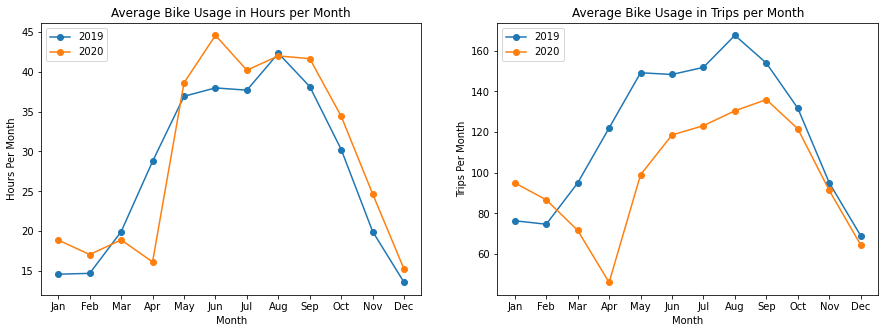

In [47]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(avg_use['2019'], marker='o', label='2019')
plt.plot(avg_use['2020'], marker='o', label='2020')
plt.title('Average Bike Usage in Hours per Month')
plt.xlabel('Month')
plt.ylabel('Hours Per Month')
plt.legend(loc="upper left")

plt.subplot(1,2,2)
plt.plot(rides['2019'], marker='o', label='2019')
plt.plot(rides['2020'], marker='o', label='2020')
plt.title('Average Bike Usage in Trips per Month')
plt.xlabel('Month')
plt.ylabel('Trips Per Month')
plt.legend(loc="upper left")

While generally Citibike usage was greater in 2020, we see an interesting decline in March 2020 with
the beginning of COVID and a dip in April 2020 activity before a spike back up to 2019 levels in May. For every remaining month of the year, average monthly bike usage in terms of hours ridden exceeded 2019 levels. However, the average number of monthly rides that each bike took was actually lower in 2020 than in 2019, implying people are taking the bikes on longer rides. Bikes on average were also being ridden for far less time in the winter months than in the summer months. 

**2.4 What are the most popular routes?**

In [48]:
#Create a dataframe df that concats each month's data horizontally
df = pd.concat(data19_20, ignore_index=True)

In [49]:
df

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,age
0,320,2019-01-01 00:01:47.4010,2019-01-01 00:07:07.5810,3160.0,Central Park West & W 76 St,40.778968,-73.973747,3283.0,W 89 St & Columbus Ave,40.788221,-73.970416,15839,Subscriber,1971,1,48
1,316,2019-01-01 00:04:43.7360,2019-01-01 00:10:00.6080,519.0,Pershing Square North,40.751873,-73.977706,518.0,E 39 St & 2 Ave,40.747804,-73.973442,32723,Subscriber,1964,1,55
2,591,2019-01-01 00:06:03.9970,2019-01-01 00:15:55.4380,3171.0,Amsterdam Ave & W 82 St,40.785247,-73.976673,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,27451,Subscriber,1987,1,32
3,2719,2019-01-01 00:07:03.5450,2019-01-01 00:52:22.6500,504.0,1 Ave & E 16 St,40.732219,-73.981656,3709.0,W 15 St & 6 Ave,40.738046,-73.996430,21579,Subscriber,1990,1,29
4,303,2019-01-01 00:07:35.9450,2019-01-01 00:12:39.5020,229.0,Great Jones St,40.727434,-73.993790,503.0,E 20 St & Park Ave,40.738274,-73.987520,35379,Subscriber,1979,1,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40007106,2045,2020-12-31 23:58:21.7040,2021-01-01 00:32:27.1570,526.0,E 33 St & 5 Ave,40.747659,-73.984907,3614.0,Crescent St & 30 Ave,40.768692,-73.924957,36467,Subscriber,1994,1,26
40007107,288,2020-12-31 23:58:37.8400,2021-01-01 00:03:26.3250,3307.0,West End Ave & W 94 St,40.794165,-73.974124,3383.0,Cathedral Pkwy & Broadway,40.804213,-73.966991,47749,Subscriber,1969,0,51
40007108,152,2020-12-31 23:58:52.8090,2021-01-01 00:01:25.6720,3510.0,Adam Clayton Powell Blvd & W 123 St,40.807832,-73.949373,3518.0,Lenox Ave & W 126 St,40.808442,-73.945209,48691,Customer,1969,0,51
40007109,654,2020-12-31 23:59:55.9550,2021-01-01 00:10:50.6050,4073.0,W 51 St & Rockefeller Plaza,40.759700,-73.978082,500.0,Broadway & W 51 St,40.762288,-73.983362,49564,Subscriber,1994,1,26


In [50]:
df.groupby(['start station name', 'end station name']).size().nlargest(5).reset_index()

,start station name,end station name,0
0,West Drive & Prospect Park West,West Drive & Prospect Park West,17948
1,Central Park S & 6 Ave,Central Park S & 6 Ave,13599
2,E 7 St & Avenue A,Cooper Square & Astor Pl,10933
3,12 Ave & W 40 St,West St & Chambers St,10496
4,12 Ave & W 40 St,12 Ave & W 40 St,9857


The most popular route of 2019 & 2020 combined is starting and ending at the West Drive & Prospect Park West location. Riders love Prospect Park!

In [51]:
# df['starttime'] = df['starttime'].astype('datetime64[ns]')
# df['year'] = df.starttime.dt.year
df['year'] = df['starttime'].str[:4].astype(int)

In [52]:
# print(df[df['year']==2019]['start_end'].value_counts().head(5))
print(df[df['year']==2019].groupby(['start station name', 'end station name']).size().nlargest(5).reset_index())

                start station name                 end station name     0
0                E 7 St & Avenue A         Cooper Square & Astor Pl  8425
1           Central Park S & 6 Ave           Central Park S & 6 Ave  6773
2           Central Park S & 6 Ave                  5 Ave & E 88 St  6086
3    North Moore St & Greenwich St         Vesey Pl & River Terrace  5365
4  West Drive & Prospect Park West  West Drive & Prospect Park West  5346


In [53]:
# print(df[df['year']==2020]['start_end'].value_counts().head(5))
print(df[df['year']==2020].groupby(['start station name', 'end station name']).size().nlargest(5).reset_index())

                start station name                 end station name      0
0  West Drive & Prospect Park West  West Drive & Prospect Park West  12602
1           Central Park S & 6 Ave           Central Park S & 6 Ave   6826
2                 12 Ave & W 40 St                 12 Ave & W 40 St   6564
3                12 Ave & W 125 St                12 Ave & W 125 St   6213
4               Broadway & W 60 St               Broadway & W 60 St   5887


Very interesting results comparing the top 5 routes of 2019 and 2020! The top 5 routes of 2020 have the same start and end locations, looks like cycling in the city that year was less so a form of transportation but rather an activity in and of itself.

**2.5 Which stations are likely to run out of bikes?**

In [54]:
df['starttime'] = df['starttime'].astype('datetime64[ns]')
df['stoptime'] = df['stoptime'].astype('datetime64[ns]')
df['starthour'] = df.starttime.dt.hour
df['stophour'] = df.stoptime.dt.hour

In [55]:
print(df[df['year']==2019]['start station name'].value_counts().head(5))

Pershing Square North    156531
E 17 St & Broadway       121579
8 Ave & W 31 St          119918
Broadway & E 22 St       112960
Broadway & E 14 St       112885
Name: start station name, dtype: int64


In [56]:
print(df[df['year']==2019]['end station name'].value_counts().head(5))

Pershing Square North    155417
E 17 St & Broadway       125266
Broadway & E 22 St       123008
8 Ave & W 31 St          121521
West St & Chambers St    115954
Name: end station name, dtype: int64


In [57]:
print(df[df['year']==2020]['start station name'].value_counts().head(5))

1 Ave & E 68 St          100690
West St & Chambers St     99256
W 21 St & 6 Ave           99042
12 Ave & W 40 St          97305
Broadway & W 60 St        91781
Name: start station name, dtype: int64


In [58]:
print(df[df['year']==2020]['end station name'].value_counts().head(5))

West St & Chambers St    101704
W 21 St & 6 Ave          100171
1 Ave & E 68 St          100129
12 Ave & W 40 St          99247
E 17 St & Broadway        93832
Name: end station name, dtype: int64


As noted previously in our report, Pershing Square North is a popular station, it is at the top of this list as starting and ending station for 2019. For 2019, top starting and ending stations are pretty similar, with the exception of Broadway & E 14 St which makes that starting list and West St & Chambers St which makes the ending list.

2020 has a few different stations than 2019, first off, Pershing Square North is no longer in the top 5! Some of the new popular stations are: 1 Ave & E 68 St, W 21 St & 6 Ave, 12 Ave & W 40 St, and Broadway & W 60 St.

We will look into a few of the stations above to see the balance of bikes going in and out. Additionally, we will look at 2019 and 2020 separately to see if Covid times were different than "normal".

In [59]:
def coming_and_going(station, year):
    plt.hist([df[(df['start station name'] == station) & (df['year'] == year)]['starthour'], df[(df['end station name'] == station) & (df['year'] == year)]['stophour']], label=['Out', 'In'])
    plt.title('# of Bikes Entering and Leaving ' + str(station) + ' in ' + str(year))
    plt.xlabel('Time of Day')
    plt.ylabel('# of Bikes')
    plt.legend(loc='upper left')
    plt.show()

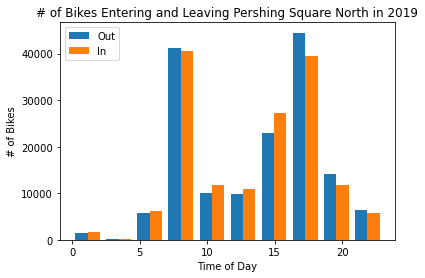

In [60]:
coming_and_going('Pershing Square North', 2019)

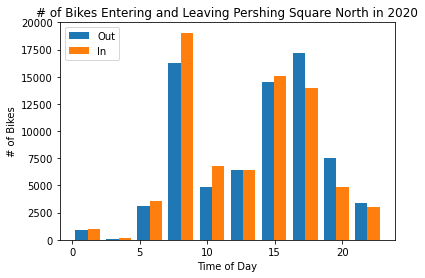

In [61]:
coming_and_going('Pershing Square North', 2020)

Looks like Pershing Square North has a healthy intake and outake of bikes throughout the day, with a slight change during rush hours.

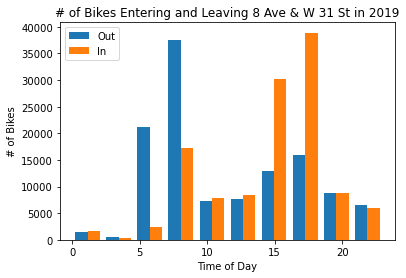

In [62]:
coming_and_going('8 Ave & W 31 St', 2019)

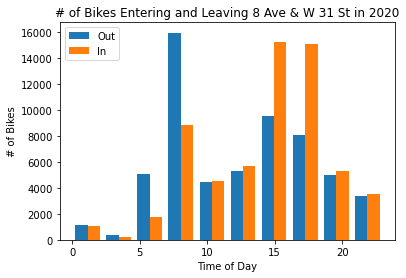

In [63]:
coming_and_going('8 Ave & W 31 St', 2020)

8 Ave & W 31 St is not quite as balance. We are seeing a lot of people taking bikes in the morning and a lot coming back in the afternoon/evening. This is something Citibike should note when distributing bikes to stations throughout the day. Don't want the station empty in the morning for those commuters!

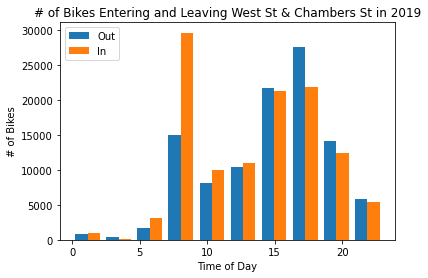

In [64]:
coming_and_going('West St & Chambers St', 2019)

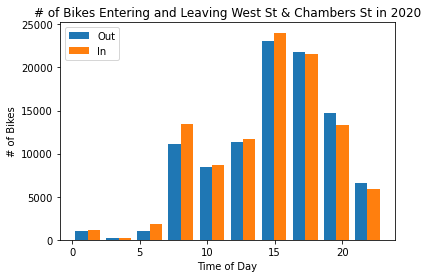

In [65]:
coming_and_going('West St & Chambers St', 2020)

In 2019, West St & Chambers St is seeing the opposite situation to 8 Ave & W 31 St. In 2019, more bikes were coming in than out in the morning. In 2020 this levels off, as potentially fewer people were coming into their Wall St. offices.

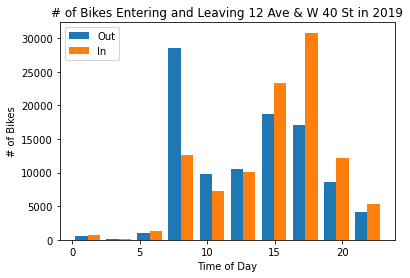

In [66]:
coming_and_going('12 Ave & W 40 St', 2019)

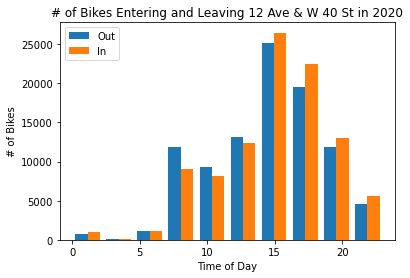

In [67]:
coming_and_going('12 Ave & W 40 St', 2020)

12 Ave & W 40 St is right next to a ferry terminal on the west side. One can theorize from these graphs that this was a large commuter station for people taking the ferry from NJ to Manhattan. 2020 is a lot more balance with the arrivals and deparatures of bikes into the station. Though interestingly enough, this station didn't make the top 5 stations of 2019, but did for 2020. Citibike should take note of 2019, for if we do return to in person work in the future, it might be worth adding an additional station near the ferry terminal for commuters.


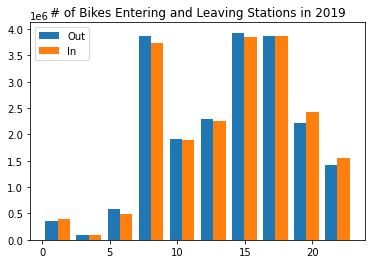

In [68]:
plt.hist([df[df['year'] ==2019]['starthour'], df[df['year'] ==2019]['stophour']], label=['Out', 'In'])
plt.title('# of Bikes Entering and Leaving Stations in 2019')
plt.legend(loc='upper left')
plt.show()

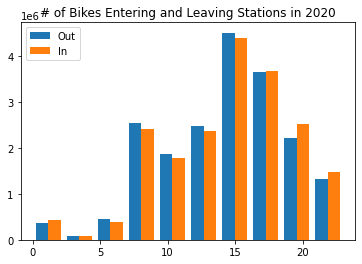

In [69]:
plt.hist([df[df['year'] ==2020]['starthour'], df[df['year'] ==2020]['stophour']], label=['Out', 'In'])
plt.title('# of Bikes Entering and Leaving Stations in 2020')
plt.legend(loc='upper left')
plt.show()

Overall, the inflow and outflow of bikes in both years seems even and well distributed. In 2019, we see our most popular times were in the morning and afternoon/early evening. Meanwhile, in 2020 morning traffic wasn't as commom, instead 3pm was the most popular time.

**2.6 What are the most popular times of day?**

In [70]:
#resetting index of all dataframes as datetimeindex of starttime
#creating new columns for day of week, weekend indicator and time in fraction form
#reset index because there are duplicate starttimes that cause issues when separating data into weekend&weekday/subscriber&customer
for indx,data in enumerate(data19_20):
    data['starttime'] = pd.to_datetime(data['starttime'])
    data=data.set_index('starttime')#index on starttime date and time stamp
    data['weekday']=data.index.strftime('%A') #create column for day of the week
    data['weekend'] = np.where((data['weekday']=='Saturday') | (data['weekday']=='Sunday'), 1, 0) #create column for weekend indicator where 1=weekend and 0=weekday 
    data['fracTime']=data.index.hour + (data.index.minute/60) #convert time to fraction for histograms
    data=data.reset_index()
    data19_20[indx]=data

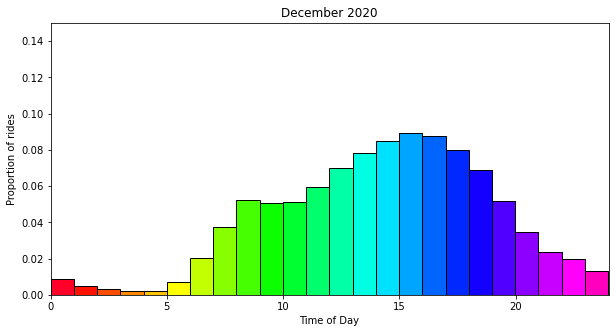

In [71]:
Hrs2019_2020 = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))

#fill the dataframe by pulling the Time (as a number out of 24) columns from each month's data
for indx, data in enumerate(data19_20):
    Hrs2019_2020[months2y[indx]] = data['fracTime']

# Create an animated histogram displaying the distribution of the rides (bike traffic)across hours of the day each month.
from IPython.display import clear_output
import time
for x in Hrs2019_2020.columns:
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    rainbow(plt.hist(Hrs2019_2020[x], bins=24, color='red', edgecolor='black', density='true'))
    plt.axis((0, 24, 0, .15))
    plt.ylabel('Proportion of rides')
    plt.xlabel('Time of Day')
    plt.title(x)
    plt.show() 
    
    time.sleep(1.0)

In [72]:
weekend_timeofDay = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))
weekday_timeofDay = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))

sub_timeofDay = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))
cust_timeofDay = pd.DataFrame(columns = months2y,index=range(most_monthly_rides))

#fill the dataframes by pulling the fraction time columns from each month's data
for indx, data in enumerate(data19_20):
    weekend_timeofDay[months2y[indx]] = data.loc[(data['weekend'] == 1), 'fracTime']
    weekday_timeofDay[months2y[indx]] = data.loc[(data['weekend'] == 0) ,'fracTime']
    
for indx, data in enumerate(data19_20):
    sub_timeofDay[months2y[indx]] = data.loc[(data['usertype'] == 'Subscriber'), 'fracTime']
    cust_timeofDay[months2y[indx]] = data.loc[(data['usertype'] == 'Customer') ,'fracTime']

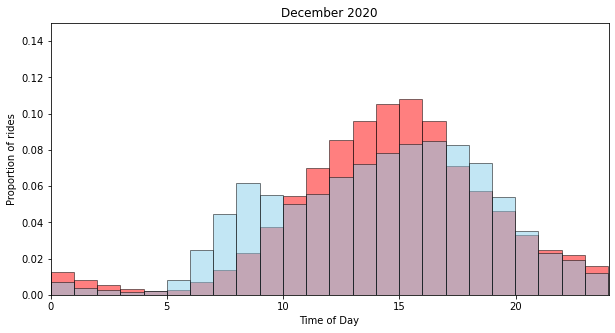

In [73]:
# Create an animated histogram displaying tie distribution of the rides by weekend vs weekday

for x in weekend_timeofDay.columns:
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.hist(weekend_timeofDay[x], bins=24, color='red', edgecolor='black', alpha=0.5, density='true')
    plt.hist(weekday_timeofDay[x], bins=24, color='skyblue', edgecolor='black', alpha=0.5, density='true')
    plt.axis((0, 24, 0, .15))
    plt.ylabel('Proportion of rides')
    plt.xlabel('Time of Day')
    plt.title(x)
    plt.show() 
    
    time.sleep(1.0)

The distribution of rides across hours of the day on weekdays is bimodal, as bike traffic seems to be heaviest between the hours of 8AM and 9AM--presumably as commuters make their way to work--and between the hours of 5 PM and 6 PM as they return from work. This is distinctly different from the more normally distibuted bike traffic during the weekend. This pattern is consistent across months until April 2020. In April 2020 and May 2020, the distribution of weekdays loses its bimodal appearance and converges towards to normal distribution of the weekend. As the shift of weekday distribution coincides with the start of the pandemic, a reasonable explanation for this change is the adoption of remote working by many workplace in New York City.  

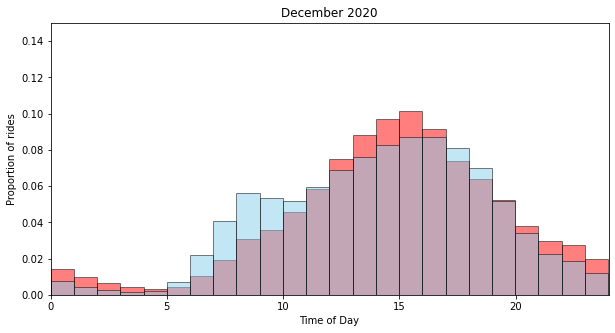

In [74]:
# Create an animated histogram displaying tie distribution of the rides by usertype

for x in sub_timeofDay.columns:
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.hist(cust_timeofDay[x], bins=24, color='red', edgecolor='black', alpha=0.5, density='true')
    plt.hist(sub_timeofDay[x], bins=24, color='skyblue', edgecolor='black', alpha=0.5, density='true')
    plt.axis((0, 24, 0, .15))
    plt.ylabel('Proportion of rides')
    plt.xlabel('Time of Day')
    plt.title(x)
    plt.show() 
    
    time.sleep(1.0)

The distribution of rides across hours of the day for subscribers is bimodal while the distribution for casual riders appears to be normal. This closely mirrors the the patterns observed for weekday vs weekend traffic, suggesting that most weekday riders are subscribers riding to and from work, while weekend riders are more often casual users. Indeed, the shift observed in April 2020 for the weekday vs weekend distributions is again present in the distributions by usertype with the subscriber distribution losing its bimodality in April and May of 2020 and appearing to converge to the distribution of casual users. 

**2.7 How did average ride duration change over time?**

In [75]:
df_copy=df.set_index("starttime")

In [76]:
df_copy

,tripduration,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,age,year,starthour,stophour
starttime,,,,,,,,,,,,,,,,,,
2019-01-01 00:01:47.401,320,2019-01-01 00:07:07.581,3160.0,Central Park West & W 76 St,40.778968,-73.973747,3283.0,W 89 St & Columbus Ave,40.788221,-73.970416,15839,Subscriber,1971,1,48,2019,0,0
2019-01-01 00:04:43.736,316,2019-01-01 00:10:00.608,519.0,Pershing Square North,40.751873,-73.977706,518.0,E 39 St & 2 Ave,40.747804,-73.973442,32723,Subscriber,1964,1,55,2019,0,0
2019-01-01 00:06:03.997,591,2019-01-01 00:15:55.438,3171.0,Amsterdam Ave & W 82 St,40.785247,-73.976673,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,27451,Subscriber,1987,1,32,2019,0,0
2019-01-01 00:07:03.545,2719,2019-01-01 00:52:22.650,504.0,1 Ave & E 16 St,40.732219,-73.981656,3709.0,W 15 St & 6 Ave,40.738046,-73.996430,21579,Subscriber,1990,1,29,2019,0,0
2019-01-01 00:07:35.945,303,2019-01-01 00:12:39.502,229.0,Great Jones St,40.727434,-73.993790,503.0,E 20 St & Park Ave,40.738274,-73.987520,35379,Subscriber,1979,1,40,2019,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:58:21.704,2045,2021-01-01 00:32:27.157,526.0,E 33 St & 5 Ave,40.747659,-73.984907,3614.0,Crescent St & 30 Ave,40.768692,-73.924957,36467,Subscriber,1994,1,26,2020,23,0
2020-12-31 23:58:37.840,288,2021-01-01 00:03:26.325,3307.0,West End Ave & W 94 St,40.794165,-73.974124,3383.0,Cathedral Pkwy & Broadway,40.804213,-73.966991,47749,Subscriber,1969,0,51,2020,23,0
2020-12-31 23:58:52.809,152,2021-01-01 00:01:25.672,3510.0,Adam Clayton Powell Blvd & W 123 St,40.807832,-73.949373,3518.0,Lenox Ave & W 126 St,40.808442,-73.945209,48691,Customer,1969,0,51,2020,23,0


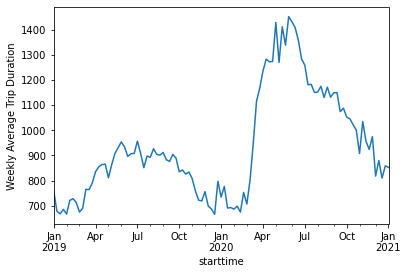

In [77]:
weekly = df_copy['tripduration'].resample('W').mean()
weekly.plot(style=['-'])
plt.ylabel('Weekly Average Trip Duration');

In April 2020, the average trip duration greatly increased (both from the previous month and as compared to April 2019). Average trip duration remained high for the following months of the pandemic and through to the fall when ride duration, as is seasonally typical, decreased.  Despite this decrease in trip length, average trip duration remained markedly higher as compared to the same time period in the previous year.

<u><h2> **Appendix: Further Exploration with Hypothesis Testing**</u></h2>

**Hypothesis tests for April 2019 and April 2020**
Consider a significance level of 0.005

In [78]:
#relevant data
data419 = pd.read_csv('201904-citibike-tripdata.csv')
data420 = pd.read_csv('202004-citibike-tripdata.csv')

In [79]:
#relevant data cleaning
datas = [data419, data420]
for data in datas:
    data['birth year'] = data['birth year'].astype(int)
    data['age'] = int(data['starttime'][0][:4]) - data['birth year']
    data19_20[indx] = data[(data['age'] <= 100) & (data['tripduration'] <= 36000)]

In [80]:
#April 2019 compared to April 2020 Trip Duration Mann Whitney U Test

tripduration2020=np.array(data420['tripduration'])
tripduration2019=np.array(data419['tripduration'])

tripduration2019 = tripduration2019[np.isfinite(tripduration2019)]
tripduration2020 = tripduration2020[np.isfinite(tripduration2020)]

from scipy import stats

print(stats.mannwhitneyu(tripduration2019,tripduration2020))

print(stats.mannwhitneyu(tripduration2019,tripduration2020, alternative='greater'))

print(stats.mannwhitneyu(tripduration2019,tripduration2020, alternative='less'))

MannwhitneyuResult(statistic=451199407294.0, pvalue=0.0)
MannwhitneyuResult(statistic=451199407294.0, pvalue=1.0)
MannwhitneyuResult(statistic=451199407294.0, pvalue=0.0)


In [81]:
#April 2019 compared to April 2020 Age Mann Whitney U Test

age2020=np.array(data420['age'])
age2019=np.array(data419['age'])

age2019 = age2019[np.isfinite(age2019)]
age2020 = age2020[np.isfinite(age2020)]

print(stats.mannwhitneyu(age2019,age2020))

print(stats.mannwhitneyu(age2019,age2020, alternative='greater'))

print(stats.mannwhitneyu(age2019,age2020, alternative='less'))

MannwhitneyuResult(statistic=571436309033.5, pvalue=0.0)
MannwhitneyuResult(statistic=571436309033.5, pvalue=1.0)
MannwhitneyuResult(statistic=571436309033.5, pvalue=0.0)


In [82]:
#Trip Duration by Gender Hypothesis Testing April 2020

dfmale=data420[data420['gender']==1]

dffemale=data420[data420['gender']==2]

tripdurationfemale=np.array(dfmale['tripduration'])
tripdurationmale=np.array(dffemale['tripduration'])

tripdurationfemale = tripdurationfemale[np.isfinite(tripdurationfemale)]
tripdurationmale = tripdurationmale[np.isfinite(tripdurationmale)]

print(stats.mannwhitneyu(tripdurationfemale,tripdurationmale))

print(stats.mannwhitneyu(tripdurationfemale,tripdurationmale, alternative='greater'))

print(stats.mannwhitneyu(tripdurationfemale,tripdurationmale, alternative='less'))

MannwhitneyuResult(statistic=34359173836.0, pvalue=0.0)
MannwhitneyuResult(statistic=34359173836.0, pvalue=1.0)
MannwhitneyuResult(statistic=34359173836.0, pvalue=0.0)


In [83]:
#Age Hypothesis Testing by Gender April 2020

agefemale=np.array(dfmale['age'])
agemale=np.array(dffemale['age'])

agefemale = agefemale[np.isfinite(agefemale)]
tripdurationmale = agemale[np.isfinite(agemale)]

print(stats.mannwhitneyu(agefemale,agemale))

print(stats.mannwhitneyu(agefemale,agemale, alternative='greater'))

print(stats.mannwhitneyu(agefemale,agemale, alternative='less'))

MannwhitneyuResult(statistic=43356167482.0, pvalue=0.0)
MannwhitneyuResult(statistic=43356167482.0, pvalue=0.0)
MannwhitneyuResult(statistic=43356167482.0, pvalue=1.0)


In [84]:
#Duration Hypothesis Testing by Customer Type April 2020

dfsub=data420[data420['usertype']=='Subscriber']
dfcust=data420[data420['usertype']=='Customer']

subduration=np.array(dfsub['tripduration'])
custduration=np.array(dfcust['tripduration'])

subduration = subduration[np.isfinite(subduration)]
tripdurationmale = custduration[np.isfinite(custduration)]

print(stats.mannwhitneyu(subduration, custduration))

print(stats.mannwhitneyu(subduration, custduration, alternative='greater'))

print(stats.mannwhitneyu(subduration, custduration, alternative='less'))

MannwhitneyuResult(statistic=27376881647.0, pvalue=0.0)
MannwhitneyuResult(statistic=27376881647.0, pvalue=1.0)
MannwhitneyuResult(statistic=27376881647.0, pvalue=0.0)


In [85]:
#Age Hypothesis Testing by Customer Type April 2020

subage=np.array(dfsub['age'])
custage=np.array(dfcust['age'])

subage = subage[np.isfinite(subage)]
custage = custage[np.isfinite(custage)]

print(stats.mannwhitneyu(subage,custage))

print(stats.mannwhitneyu(subage,custage, alternative='greater'))

print(stats.mannwhitneyu(subage,custage, alternative='less'))

MannwhitneyuResult(statistic=43722902345.5, pvalue=2.547844133616456e-29)
MannwhitneyuResult(statistic=43722902345.5, pvalue=1.273922066808228e-29)
MannwhitneyuResult(statistic=43722902345.5, pvalue=1.0)


In [86]:
#Age Hypothesis Testing by Customer Type April 2020

subage=np.array(dfsub['age'])
custage=np.array(dfcust['age'])

subage = subage[np.isfinite(subage)]
custage = custage[np.isfinite(custage)]

print(stats.mannwhitneyu(subage,custage))

print(stats.mannwhitneyu(subage,custage, alternative='greater'))

print(stats.mannwhitneyu(subage,custage, alternative='less'))

MannwhitneyuResult(statistic=43722902345.5, pvalue=2.547844133616456e-29)
MannwhitneyuResult(statistic=43722902345.5, pvalue=1.273922066808228e-29)
MannwhitneyuResult(statistic=43722902345.5, pvalue=1.0)
